In [1]:

from __future__ import print_function, division

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.model_selection import train_test_split

 

In [3]:
#447(357, 90) , 228( 182, 46) 
data_transforms = transforms.Compose([
        transforms.CenterCrop(800),
        transforms.Resize(122),
        #transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

In [ ]:

data_dir = 'data'


image_datasets = datasets.ImageFolder(os.path.join(data_dir), data_transforms)
class_names = image_datasets.classes

In [4]:
len(image_datasets)
 

243

In [16]:
class_names

['train', 'val']

In [5]:
train_size = int( 0.8 * len(image_datasets))
test_Size = len(image_datasets) - train_size 

train_set , test_set = torch.utils.data.random_split(image_datasets , [train_size , test_Size])
  
    
train_loader = torch.utils.data.DataLoader(train_set , batch_size = 4 , shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set , batch_size = 4 , shuffle = True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
len(train_set)

 

194

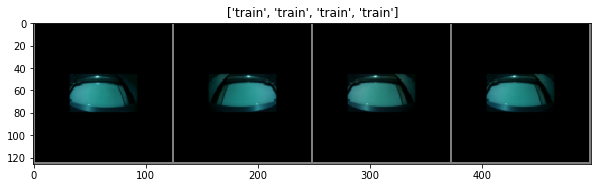

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
   
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(train_loader))

 
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(10,10))
imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer):
    running_loss = 0 
    running_corrects = 0 

    model.train()  # 모델을 학습 모드로 설정
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * running_corrects.double() /  len(train_loader.dataset)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
 


In [9]:
def test_model(model):
 
    best_acc = 0.0
    model.eval()   

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
 
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100 * running_corrects.double() / len(test_loader.dataset)


    if epoch_acc > best_acc:
        best_acc = epoch_acc

    print('test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print()
    print('Best val Acc: {:4f}'.format(best_acc))
 
    return best_acc

In [10]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(5,5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                ax.set_title('predicted: {} , labels : {}'.format(class_names[preds[j]] , class_names[labels[j]]))
                #imshow(inputs.cpu().data[j])
                    
                ##
                out = torchvision.utils.make_grid(inputs.data[j])

                plt.figure(figsize=(10,10))
                imshow(out)
                ##
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, output_dim=12):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5, padding=2, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 5, padding=2, stride=2)

        self.fc1 = nn.Linear(294, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
model_cnn = SimpleCNN().to(device)

#model_cnn = models.resnet18().to(device)

In [13]:
 
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer = optim.Adam(model_cnn.parameters())
 

In [14]:
num_epochs = 20

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    train_model(model_cnn, criterion, optimizer)
    best_acc = test_model(model_cnn)

Epoch 0/19
----------
train Loss: 0.4192 Acc: 78.3505
test Loss: 0.4035 Acc: 87.7551

Best val Acc: 87.755102
Epoch 1/19
----------
train Loss: 0.2586 Acc: 92.7835
test Loss: 0.5000 Acc: 87.7551

Best val Acc: 87.755102
Epoch 2/19
----------
train Loss: 0.3049 Acc: 92.7835
test Loss: 0.3748 Acc: 87.7551

Best val Acc: 87.755102
Epoch 3/19
----------
train Loss: 0.2718 Acc: 92.7835
test Loss: 0.3714 Acc: 87.7551

Best val Acc: 87.755102
Epoch 4/19
----------
train Loss: 0.2908 Acc: 92.7835
test Loss: 0.3748 Acc: 87.7551

Best val Acc: 87.755102
Epoch 5/19
----------
train Loss: 0.2691 Acc: 92.7835
test Loss: 0.3713 Acc: 87.7551

Best val Acc: 87.755102
Epoch 6/19
----------
train Loss: 0.2752 Acc: 92.7835
test Loss: 0.3797 Acc: 87.7551

Best val Acc: 87.755102
Epoch 7/19
----------
train Loss: 0.2688 Acc: 92.7835
test Loss: 0.4194 Acc: 87.7551

Best val Acc: 87.755102
Epoch 8/19
----------
train Loss: 0.2762 Acc: 92.7835
test Loss: 0.3982 Acc: 87.7551

Best val Acc: 87.755102
Epoch 9/19

In [15]:
def visualize_model1(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                ax.set_title('predicted: {} , labels : {}'.format(class_names[preds[j]] , class_names[labels[j]]))
                #imshow(inputs.cpu().data[j])
                ##
                out = torchvision.utils.make_grid(inputs.data[j])
                fig = plt.figure(figsize=(12,12))
                imshow(out)
                ##
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

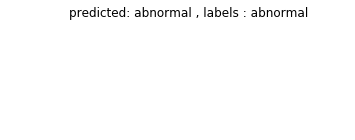

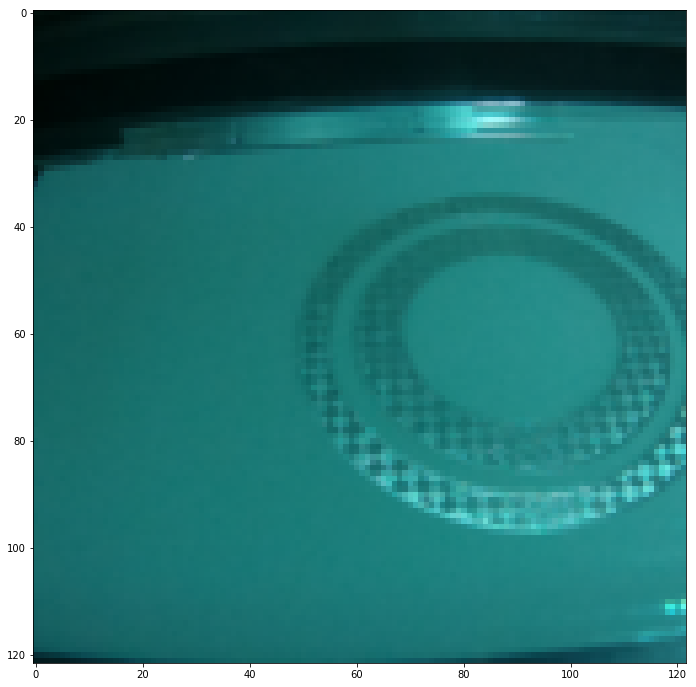

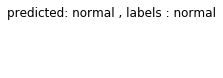

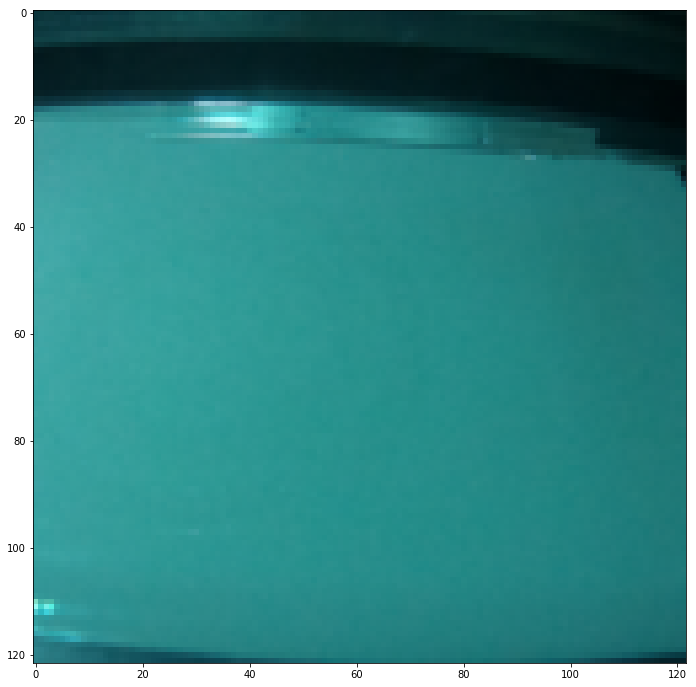

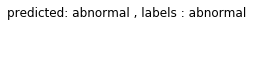

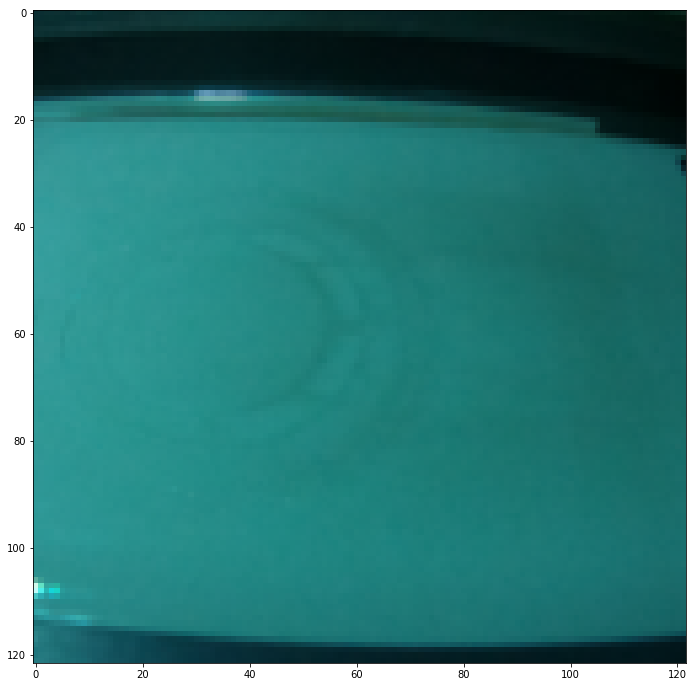

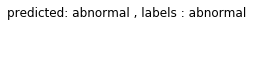

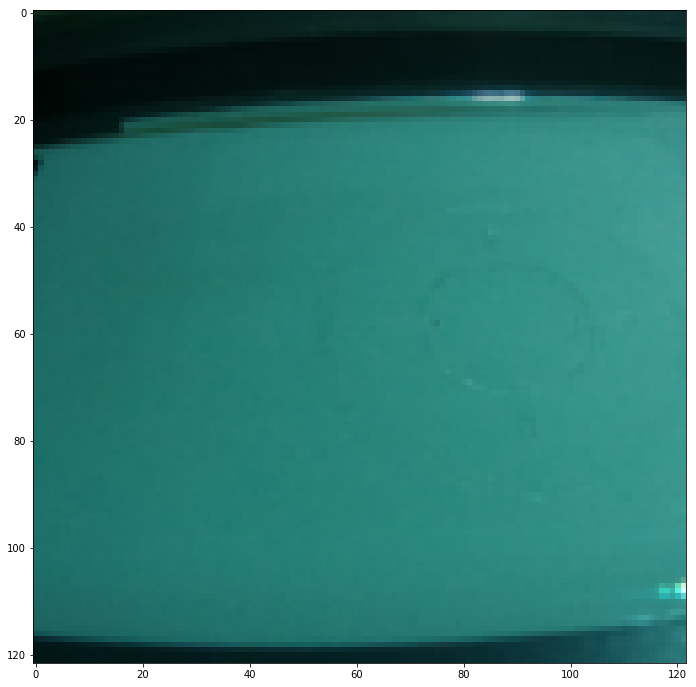

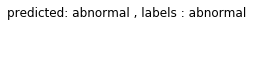

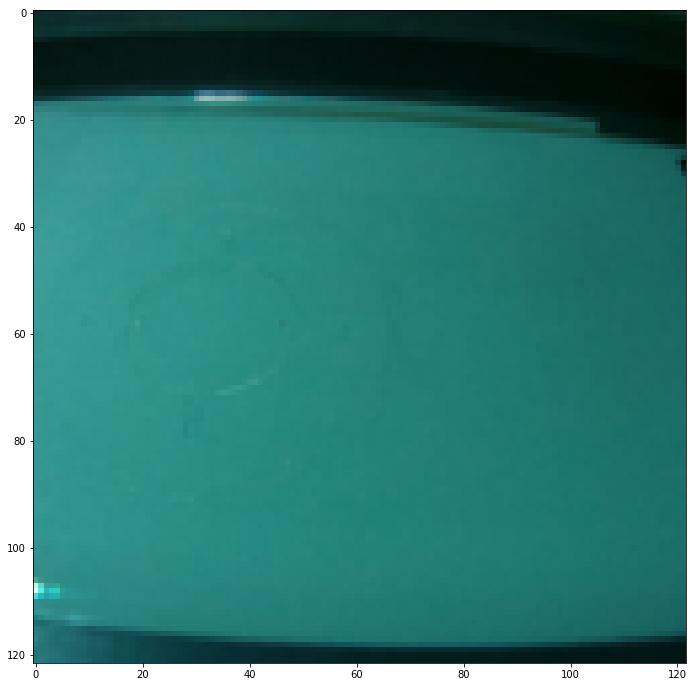

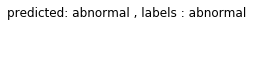

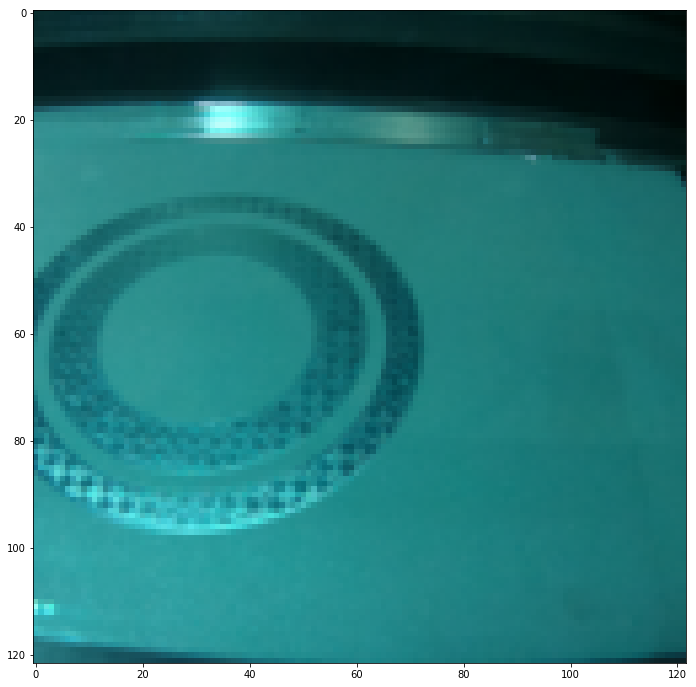

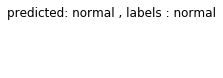

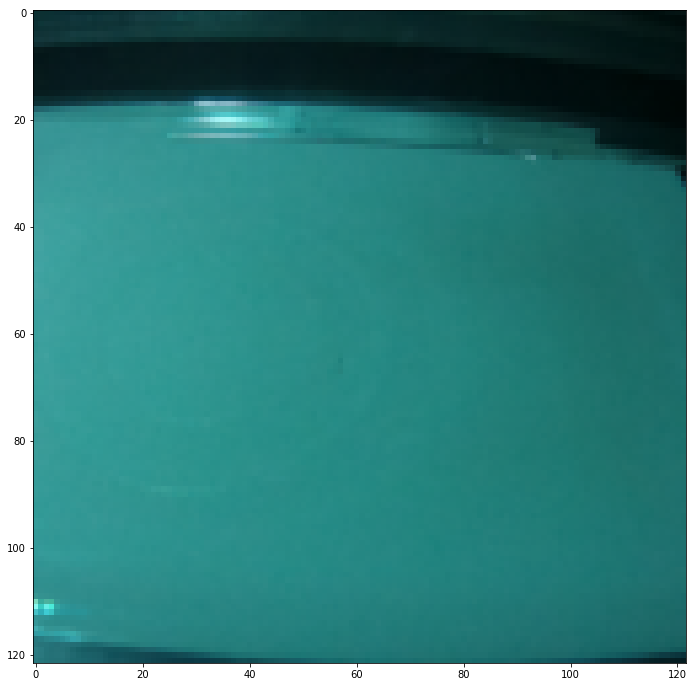

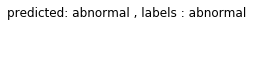

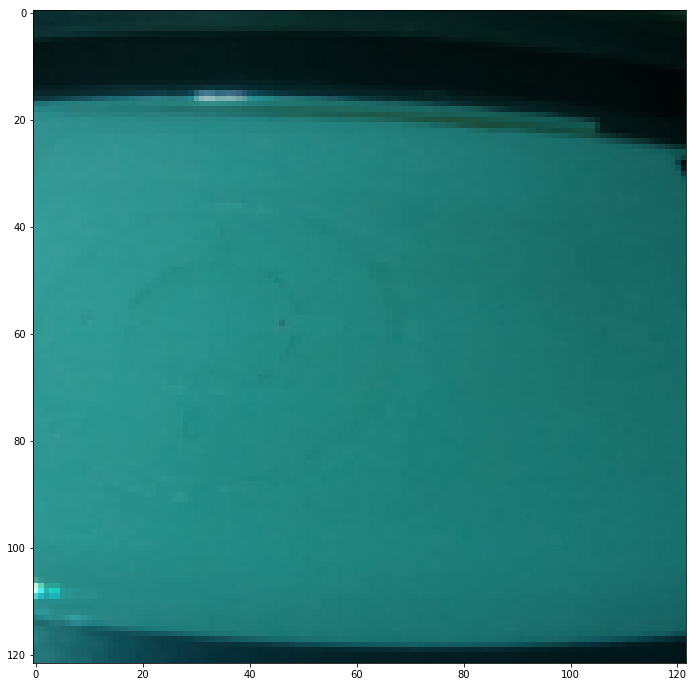

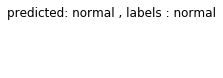

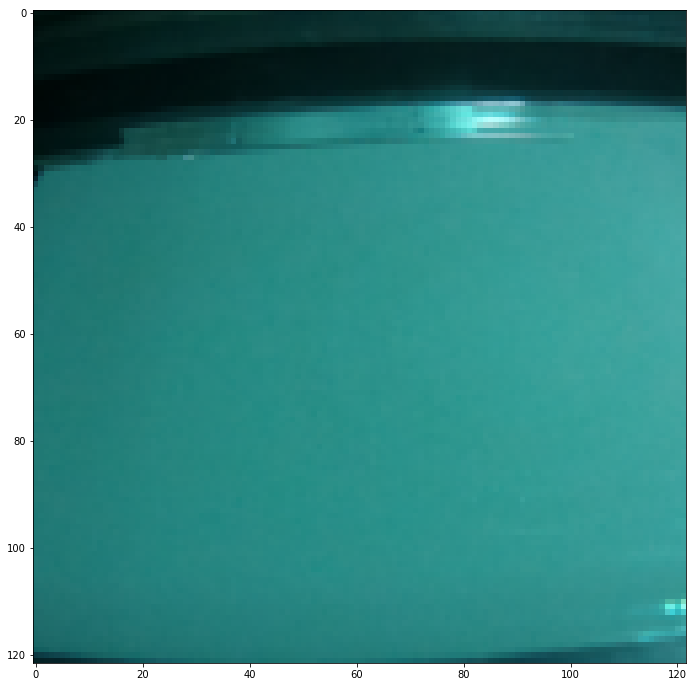

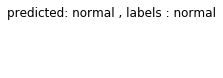

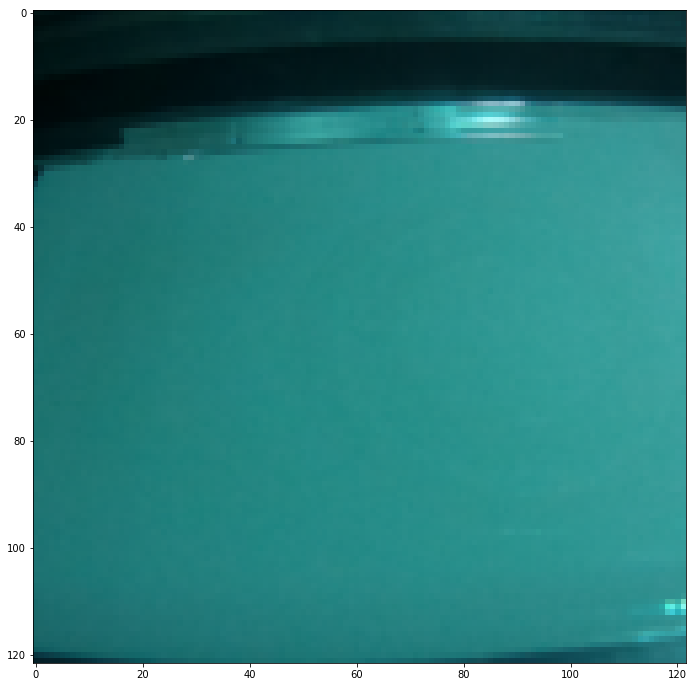

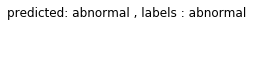

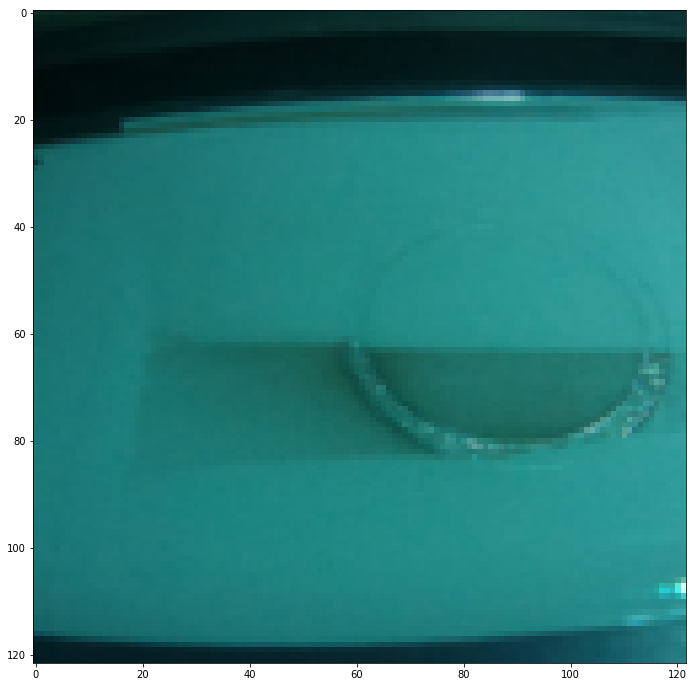

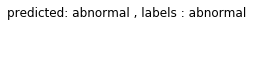

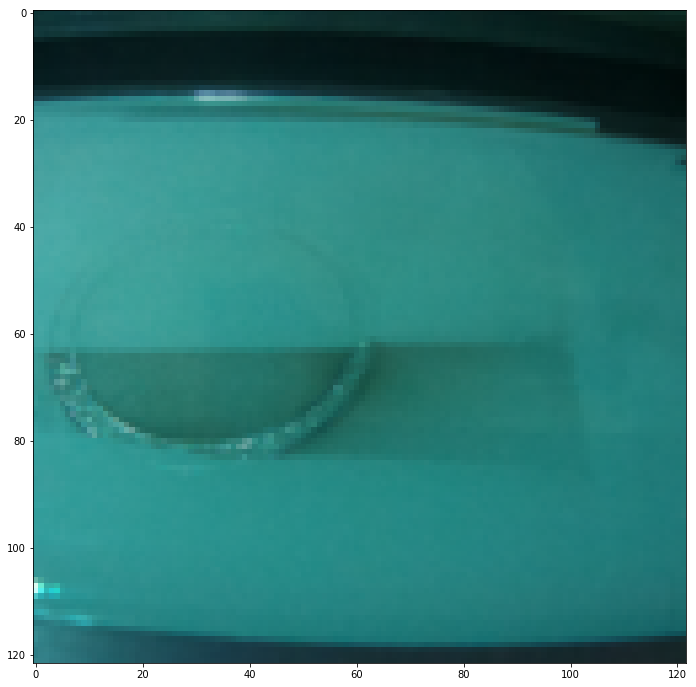

In [189]:
visualize_model1(model_cnn)